<h1>Downloading yfinance</h1>

In [3]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


<h1>Downloading numpy<2</h1>

In [4]:
!pip install "numpy<2" --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.32.0 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.0 which is incompatible.


<h1>Import Libraries</h1>

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score


<h1>Top 10 Indian Stock Markets</h1>

In [3]:
stocks = [
    "RELIANCE.NS", "HDFCBANK.NS", "TCS.NS", "INFY.NS",
    "ICICIBANK.NS", "SBIN.NS", "BHARTIARTL.NS",
    "BAJFINANCE.NS", "HINDUNILVR.NS", "LT.NS"
]

<h1>Download Historical data</h1>

In [4]:
print("Downloading the top 10 Indian stocks")
for ticker in stocks:
    data = yf.download(ticker, start="2010-01-01")
    if data.empty:
        continue


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<h2>Choose the stock</h2>

In [5]:
ticker = "INFY.NS"
print(f"\nTraining model for {ticker}")



Training model for INFY.NS


<h1>Feature Engineering</h1>

In [6]:
# Returns
data['Return'] = data['Close'].pct_change()

# Moving Averages
data['MA20'] = data['Close'].rolling(20).mean()
data['MA50'] = data['Close'].rolling(50).mean()

# Volatility
data['Volatility'] = data['Return'].rolling(20).std()

# Volume change
data['Volume_Change'] = data['Volume'].pct_change()

# RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))


<h1>Visualization</h1>

<h3>
🔵 Close Price
<br>
🟠 MA20 (20-day Moving Average)
<br>
🟢 MA50 (50-day Moving Average)
<h3>

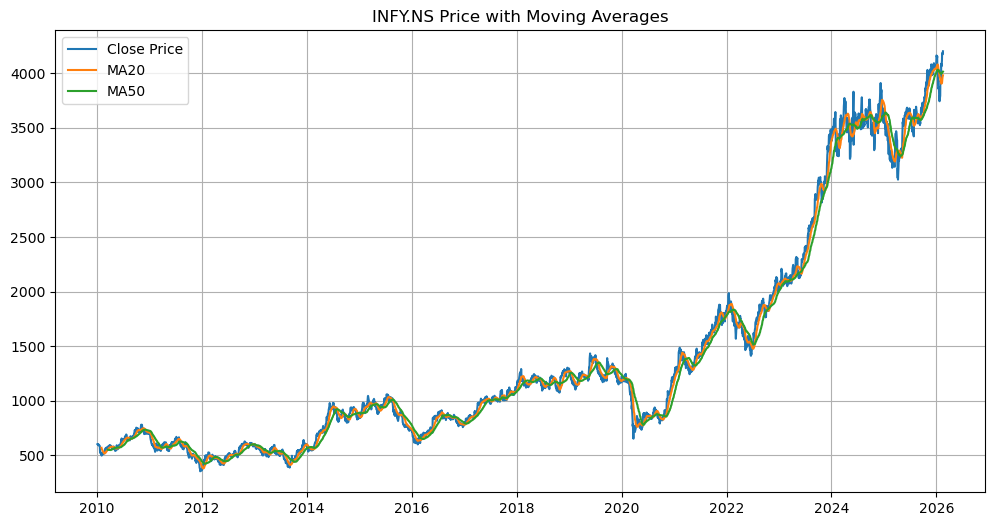

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Close Price")
plt.plot(data.index, data['MA20'], label="MA20")
plt.plot(data.index, data['MA50'], label="MA50")
plt.title(f"{ticker} Price with Moving Averages")
plt.legend()
plt.grid(True)
plt.show()


<h1>Target creation</h1>

In [8]:
data['Future_Return'] = data['Close'].shift(-5) / data['Close'] - 1

data['Signal'] = np.where(
    data['Future_Return'] > 0.02, 1,
    np.where(data['Future_Return'] < -0.02, -1, 0)
)


<h1>Clean Data</h1>

In [9]:
# Clean data safely
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

print("Total rows after cleaning:", len(data))

if len(data) < 200:
    raise ValueError("Not enough data. Increase date range.")


Total rows after cleaning: 3923


<h1>Select Features</h1>

In [10]:
features = ['Return', 'MA20', 'MA50', 'Volatility', 'Volume_Change', 'RSI']
X = data[features]
y = data['Signal']


In [11]:
print("\n Feature Values (First 5 Rows) of Infosys stock:\n")
print(X.head())


 Feature Values (First 5 Rows) of Infosys stock:

Price         Return        MA20        MA50 Volatility Volume_Change  \
Ticker                                                                  
Date                                                                    
2010-03-17  0.017352  553.984494  552.100131   0.011292      0.665345   
2010-03-18 -0.006853  556.510156  551.560366   0.011149     -0.359951   
2010-03-19  0.003404  559.099185  551.038453   0.011126     -0.021733   
2010-03-22 -0.004287  561.524893  550.600790   0.011289     -0.101872   
2010-03-23  0.000496  563.731055  550.226311   0.011272     -0.150023   

Price             RSI  
Ticker                 
Date                   
2010-03-17  75.970329  
2010-03-18  68.318984  
2010-03-19  64.563121  
2010-03-22  57.973081  
2010-03-23  60.565479  


<h1>Time-Series Train-Test Split</h1>

In [12]:
split = int(len(data) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]


<h1>Scaling</h1>

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<h1>Train Random Forest Model</h1>

In [14]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

<h1>Evaluation</h1>

In [18]:
predictions = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print("\n Model Accuracy:", round(accuracy * 100, 2), "%")
print("\nClassification Report of the Infosys stock :\n")
print(classification_report(y_test, predictions))



 Model Accuracy: 34.52 %

Classification Report of the Infosys stock :

              precision    recall  f1-score   support

          -1       0.23      0.08      0.11       156
           0       0.50      0.26      0.34       396
           1       0.30      0.67      0.41       233

    accuracy                           0.35       785
   macro avg       0.34      0.34      0.29       785
weighted avg       0.38      0.35      0.32       785



<h1>Save Model</h1>

In [16]:
pickle.dump(model, open(f"{ticker}_model.pkl", "wb"))
pickle.dump(scaler, open(f"{ticker}_scaler.pkl", "wb"))
pickle.dump(features, open(f"{ticker}_features.pkl", "wb"))

print(f"\n✅ {ticker} model saved successfully!")



✅ INFY.NS model saved successfully!
